<a href="https://colab.research.google.com/github/hmobley/liveproject_water/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification</span> (Manning Publications)<br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 5: Deliverable Solution </strong><br/>
    </p>   

#### Preliminaries for Colab

Like Part 3 and 4, below are some convenience functions for those working on Google Colab with a GPU runtime

In [43]:
#colab = 0
colab = 1

if colab==1:
    %tensorflow_version 2.x
    !pip install --default-timeout=1000 tensorflow-gpu==2.0   

In [44]:
load_res_dice_mix_history = 1
if load_res_dice_mix_history:
  import pickle

In [45]:
# must be a pre-written method for this!
def clear_drive():
  if colab == 1:
    !rm -r nwpu_images
    !rm -r nwpu_label_images
    !rm -r s2cloudless_imagery
    !rm -r s2cloudless_label_imagery
    !rm nwpu_images.zip
    !rm nwpu_label_images.zip
    !rm opt_model_1_early
    !rm opt_model_1_early_hist
    !rm opt_model_2_big
    !rm opt_model_2_big_hist
    !rm opt_model_3_bn
    !rm opt_model_3_bn_hist
    !rm opt_model_4_res
    !rm opt_model_4_res_hist
    !rm opt_model_5_res_dice
    !rm opt_model_5_res_dice_hist
    !rm opt_model_6_res_dice2
    !rm opt_model_6_res_dice2_hist
    !rm s2cloudless_imagery.zip
    !rm s2cloudless_label_imagery.zip
    !rm res_unet8.h5
    !rm res_dice_unet2.h5
    !rm -r weights

In [46]:
clear_drive()

rm: cannot remove 'opt_model_1_early': No such file or directory
rm: cannot remove 'opt_model_1_early_hist': No such file or directory
rm: cannot remove 'opt_model_2_big': No such file or directory
rm: cannot remove 'opt_model_2_big_hist': No such file or directory
rm: cannot remove 'opt_model_3_bn': No such file or directory
rm: cannot remove 'opt_model_3_bn_hist': No such file or directory
rm: cannot remove 'opt_model_4_res': No such file or directory
rm: cannot remove 'opt_model_4_res_hist': No such file or directory
rm: cannot remove 'opt_model_5_res_dice': No such file or directory
rm: cannot remove 'opt_model_5_res_dice_hist': No such file or directory
rm: cannot remove 'opt_model_6_res_dice2': No such file or directory
rm: cannot remove 'opt_model_6_res_dice2_hist': No such file or directory
rm: cannot remove 'res_unet8.h5': No such file or directory
rm: cannot remove 'res_dice_unet2.h5': No such file or directory
rm: cannot remove 'weights': No such file or directory


In [47]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
False


Convenience functions if you need to download example (minimal) imagery sets derived from NWPU and Sentinel-2 cloudless:

In [48]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#s2 cloudless imagery
file_id = '1iMfIjr_ul49Ghs2ewazjCt8HMPfhY47h'
destination = 's2cloudless_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#s2 cloudless labels
file_id = '1c7MpwKVejoUuW9F2UaF_vps8Vq2RZRfR'
destination = 's2cloudless_label_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu imagery
file_id = '1gtuqy1VlU8-M5IEMnmiSuTlI5PxQPnGB'
destination = 'nwpu_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu labels
file_id = '1W5LGbcYAcFbG5YjLgX_ekBn0u5Rno35x'
destination = 'nwpu_label_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)                        

In [49]:
import zipfile
def unzip(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()
        
if colab==1:
    unzip('s2cloudless_imagery.zip')
    unzip('s2cloudless_label_imagery.zip')   
    unzip('nwpu_images.zip')
    unzip('nwpu_label_images.zip')       

#### Install libraries

Uncomment below to install the module and its dependencies:

In [50]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ixsmtb51
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ixsmtb51
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp36-cp36m-linux_x86_64.whl size=2226033 sha256=adbafcadf42300dcfecb45d1e817c0a4c2fe0b74a216f6ae44447e47c9b62ec3
  Stored in directory: /tmp/pip-ephem-wheel-cache-byd0f6cw/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf


Import the libraries we will need:

In [51]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels
import numpy as np

#### Define U-Resnet and CRF models

In [52]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [53]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [54]:
def crf_labelrefine(input_image, predicted_labels):
    
    compat_spat=10
    compat_col=30
    theta_spat = 20
    theta_col = 80
    num_iter = 7
    num_classes = 2
    
    h, w = input_image.shape[:2] #get image dimensions
    
    d = densecrf.DenseCRF2D(w, h, 2) #create a CRF object

    # For the predictions, densecrf needs 'unary potentials' which are labels (water or no water)
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    
    # set the unary potentials to CRF object
    d.setUnaryEnergy(predicted_unary)

    # to add the color-independent term, where features are the locations only:
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    # to add the color-dependent term, i.e. 5-dimensional features are (x,y,r,g,b) based on the input image:    
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    
    # since refined_predictions will be a 2 x width x height array, 
    # each slice respresenting probability of each class (water and no water)
    # therefore we return the argmax over the zeroth dimension to return a mask
    return np.argmax(refined_predictions,axis=0)

#### Define Training functions (generators and callbacks)

In [55]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>200).astype('int')
        
        mask = mask[:n,:n]
        
        # use CRF to refine mask before it is used as a label
        mask = crf_labelrefine(raw, mask).squeeze()

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [56]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f's2cloudless_imagery/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100    
        
        # use CRF to refine mask before it is used as a label
        msk = crf_labelrefine(raw, msk).squeeze()
      
        msk = np.stack((msk,)*3, axis=-1)
          
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

In [57]:
def build_callbacks(filepath, min_delta, min_lr, factor):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=5) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=5, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks  

#### Define the loss function and compile the ResidualUNet model

In [58]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [59]:
model = res_unet((512, 512, 3), 32)
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])

#### Define training hyper-parameters, test/train files and such

In [60]:
#split into training and testing
train_files = os.listdir('nwpu_images/data')
test_files  = os.listdir('s2cloudless_imagery/data')

# a tolerance for the training. 
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.8

batch_size = 2

filepath = 'res_dice_crf_unet'+str(batch_size)+'.h5'

#### Create file generators and run model training

#### Test NWPU model on S2 imagery

First, set up a new generator function to generate batches of S2 augmented imagery and associated labels. Then, define a function that will use the model (trained on NWPU imagery) to estimate the binary semantic segmentation mask for 100 images. Finally, we'll look at the mean IOU score, and their distribution

In [61]:
def image_batch_generatorS2(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f's2cloudless_imagery/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('s2cloudless_imagery','s2cloudless_label_imagery')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>100).astype('int')

        # use CRF to refine mask before it is used as a label
        mask = crf_labelrefine(raw, mask).squeeze()
    
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [62]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generatorS2(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

285
20


In [65]:
if load_res_dice_mix_history:
  file_id = '116D4NpWzp_lXksXBD7kgL3KD_MFDNBLF'
  destination = 'opt_model_7_res_dice_mix_hist'
  if colab == 1:
    download_file_from_google_drive(file_id, destination)
  with open("opt_model_7_res_dice_mix_hist", "rb") as file_pi:
    res_dice_history = pickle.load(file_pi)
  file_id = '1lH_fSh3AV-vC3W1kCmLGUeXr51ngxvZ_'
  destination = 'opt_model_7_res_dice_mix'
  if colab == 1:
    download_file_from_google_drive(file_id, destination)
  model = tf.keras.models.load_model('opt_model_7_res_dice_mix',
                                     custom_objects={'dice_coef_loss': dice_coef_loss,
                                                     'dice_coef': dice_coef})
elif colab == 1:
  res_dice_history = model.fit_generator(train_generator,
                                         epochs = 100, 
                                         steps_per_epoch = train_steps,
                                         validation_data = test_generator, 
                                         validation_steps = test_steps,
                                         callbacks = build_callbacks(filepath, 
                                                                     min_delta, 
                                                                     min_lr, 
                                                                     factor), 
                                         verbose = 0,
                                         use_multiprocessing=True)

In [66]:
if load_res_dice_mix_history == 0 and colab == 1:
  #save model and history to load or graph later
  model.save("opt_model_7_res_dice_mix",save_format="h5")
  
  with open('opt_model_7_res_dice_mix_hist', 'wb') as file_pi:
    pickle.dump(res_dice_history.history, file_pi)# save model and history to load or graph later
  
  #del model

In [67]:
def mean_iou(y_true, y_pred):
    yt0 = y_true.squeeze()
    yp0 = tf.keras.backend.cast(y_pred.squeeze() > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# a function for getting a CRF-refined estimated water mask from an input image, 
# and IOU score evaluated against the real mask
def get_pred(x, y):
    #predict the mask 
    pred = model.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = pred.squeeze()
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    # use CRF to refine mask before it is used as a label
    msk = crf_labelrefine(x.squeeze(), msk).squeeze()
        
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou(y, msk)

In [68]:
all_files = os.listdir('s2cloudless_imagery/data')
shuffle(all_files)

Let's see how this will work:

(-0.5, 511.5, 511.5, -0.5)

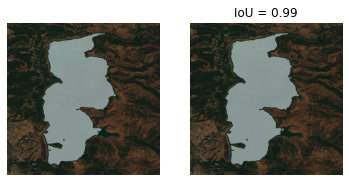

In [69]:
# run the S2 generator function
test_generatorS2  = image_batch_generatorS2(all_files, batch_size = batch_size)

#get a batch of S2 imagery and labels
x, y = next(test_generatorS2) 
#get the predicted mask and iou score for the first
ypred, iou = get_pred(x[0], y[0]) 

#make a plot side-by-side of label ...
plt.subplot(121)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
plt.axis('off')

# ... and estimated label
plt.subplot(122)
plt.imshow(x[0])
plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
plt.title('IoU = '+str(iou.numpy())[:4])
plt.axis('off')

For up to 100 images, make a prediction and store the mean iou statistic. Print a validation example every 5th image

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


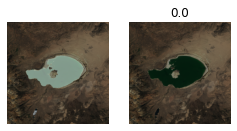

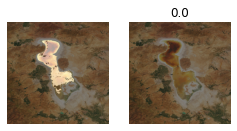

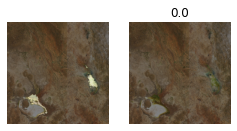

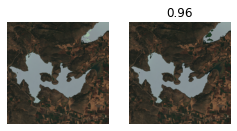

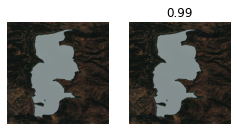

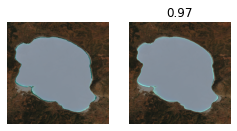

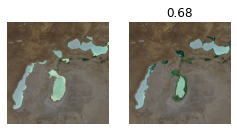

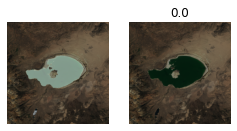

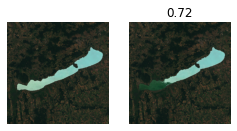

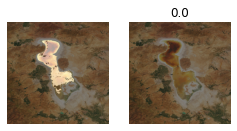

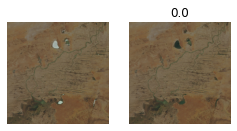

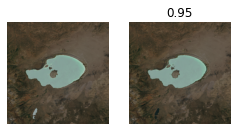

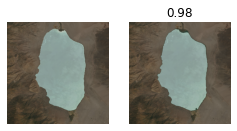

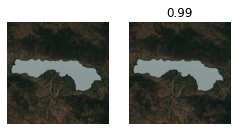

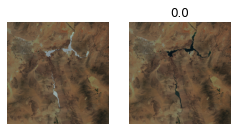

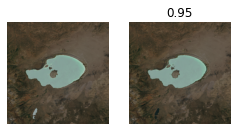

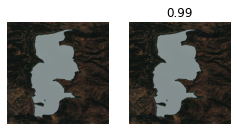

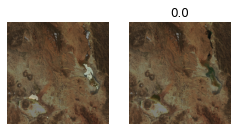

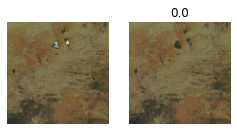

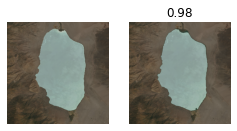

In [70]:
%matplotlib inline
IOU = [] #initialize list
counter = 0 #initialize counter
while counter < 100: # compare 100 images
    x, y = next(test_generatorS2)
    ypred, iou = get_pred(x[0], y[0])
    IOU.append(iou) #update list

    if counter % 5 == 0: #print every 5th comparison
        plt.figure(figsize=(4,6))
        plt.subplot(121)
        plt.imshow(x[0])
        plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(x[0])
        plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
        plt.title(str(iou.numpy())[:4])
        plt.axis('off')
        print(counter)  
        
    counter += 1 #update counter

Print the median IOU score to screen and make a histogram plot of the distribution of IOU scores

In [71]:
print(np.median(IOU))

0.9283384


There are 3 peaks in the histogram; the first at IoU ~ 0 where the algorithm didn't detect a lake at all (about 10% of samples), the second around ~0.5 where only one lake out of many were detected, and finally the biggest peak around ~0.95 accoting for about 70% of samples

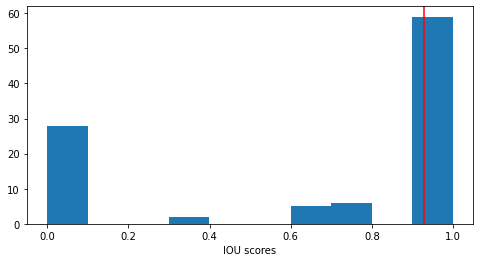

In [72]:
%matplotlib inline
fliers = dict(markerfacecolor='g', marker='p')
plt.figure(figsize=(8,4))
plt.hist(IOU)
plt.xlabel('IOU scores')
plt.axvline(np.median(IOU), color='r')

#### Combine two models in an ensemble prediction

Create two models and use the ```load_weights``` utility to load the weights contained in the h5 files (the product of model training)

In [73]:
#file_id = '1BEw63yYh1Wt6Dbz85gm-U1wmi2Nyddbo'
#destination = 'opt_model_5_res_dice'
#if colab==1:
#    download_file_from_google_drive(file_id, destination)
file_id = '1QgJqz2el-9it4e9rAUUeQgWMpZbcMlKL'
destination = 'opt_model_6_res_dice2'
if colab==1:
    download_file_from_google_drive(file_id, destination)

In [74]:
if colab==1:
  m1 = tf.keras.models.load_model('opt_model_6_res_dice2',
                                  custom_objects = {"dice_coef_loss":dice_coef_loss,
                                                    "dice_coef":dice_coef})
#m2 = tf.keras.models.load_model('opt_model_7_res_dice_mix',
#                               custom_objects = {"dice_coef_loss":dice_coef_loss,
#                                                "dice_coef":dice_coef})
#m2 = tf.keras.models.load_model('opt_model_5_res_dice',
#                               custom_objects = {"dice_coef_loss":dice_coef_loss,
#                                                "dice_coef":dice_coef})


In [75]:
if colab==1:
    #!mkdir weights
    m1.save_weights('res_dice_crf_unet1.h5')
    model.save_weights('res_dice_crf_unet2.h5')
    #m2.save_weights('res_dice_unet2.h5')

In [76]:
model1 = res_unet((512, 512, 3), 32)
model1.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model1.load_weights('res_dice_crf_unet1.h5')

model2 = res_unet((512, 512, 3), 32)
model2.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model2.load_weights('res_dice_crf_unet2.h5')

Now update the `get_pred` function to use the maximum of the two model outputs on an input image

In [77]:
# a function for getting a CRF-refined estimated water mask from an input image, 
# and IOU score evaluated against the real mask
def get_pred(x, y, model1, model2):
    #predict the mask 
    pred1 = model1.predict(np.expand_dims(x, 0))
    pred2 = model2.predict(np.expand_dims(x, 0))
    
    #mask post-processing 
    msk  = np.maximum(pred1.squeeze(), pred2.squeeze())
    # binarize
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0
    
    # use CRF to refine mask before it is used as a label
    msk = crf_labelrefine(x.squeeze(), msk).squeeze()
        
    # return the prediction and the IOU score of the prediction
    return msk, mean_iou(y, msk)

Test things, like you did earlier

(-0.5, 511.5, 511.5, -0.5)

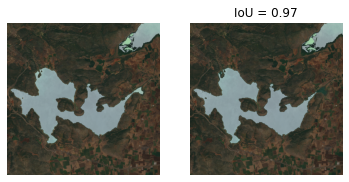

In [78]:
# run the S2 generator function
test_generatorS2  = image_batch_generatorS2(all_files, batch_size = batch_size)

#get a batch of S2 imagery and labels
x, y = next(test_generatorS2) 
#get the predicted mask and iou score for the first
ypred, iou = get_pred(x[0], y[0], model1, model2) 

#make a plot side-by-side of label ...
plt.subplot(121)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
plt.axis('off')

# ... and estimated label
plt.subplot(122)
plt.imshow(x[0])
plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
plt.title('IoU = '+str(iou.numpy())[:4])
plt.axis('off')

Just like before, for up to 100 images, make a prediction using both models, and store the mean iou statistic. Print a validation example every 5th image

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


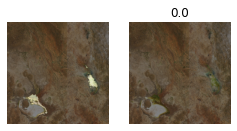

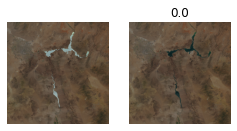

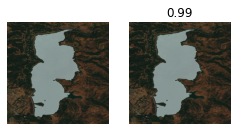

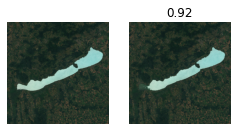

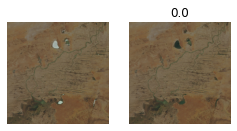

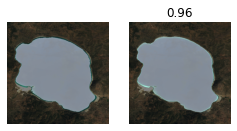

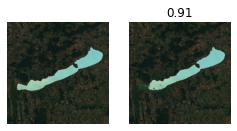

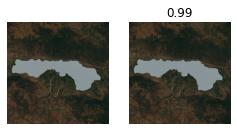

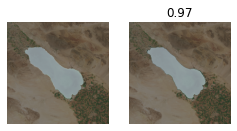

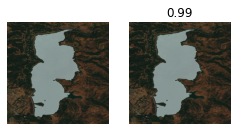

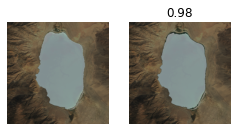

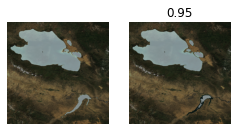

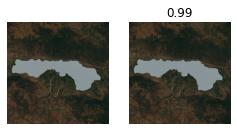

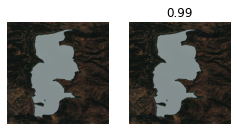

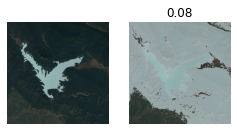

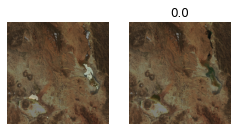

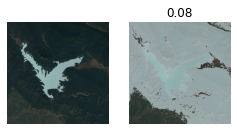

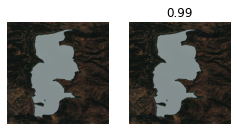

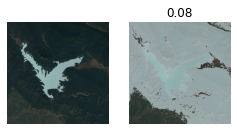

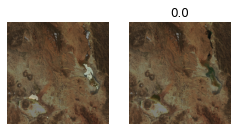

In [79]:
%matplotlib inline
IOU = [] #initialize list
counter = 0 #initialize counter
while counter < 100: # compare 100 images
    x, y = next(test_generatorS2)
    ypred, iou = get_pred(x[0], y[0], model1, model2)
    IOU.append(iou) #update list

    if counter % 5 == 0: #print every 5th comparison
        plt.figure(figsize=(4,6))
        plt.subplot(121)
        plt.imshow(x[0])
        plt.imshow(y[0].squeeze(), alpha=0.5, cmap='gray')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(x[0])
        plt.imshow(ypred.squeeze(), alpha=0.5, cmap='gray')
        plt.title(str(iou.numpy())[:4])
        plt.axis('off')
        print(counter)  
        
    counter += 1 #update counter

compute the median, and show the histograms of IOUs. As you can see, ensemble predictions are a very simple way to improve predictions

In [80]:
print(np.median(IOU))    

0.94258666


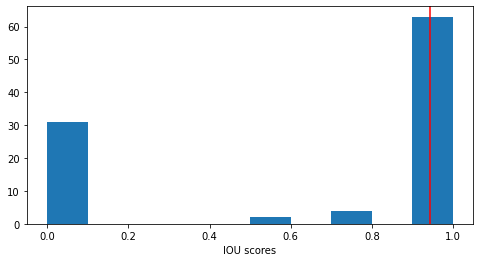

In [81]:
%matplotlib inline
fliers = dict(markerfacecolor='g', marker='p')
plt.figure(figsize=(8,4))
plt.hist(IOU)
plt.xlabel('IOU scores')
plt.axvline(np.median(IOU), color='r')